In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps

import xtrack as xt
import xpart as xp
import xobjects as xo
import xcoll as xc

In [2]:
line = xt.Line.from_json('../../injection_lines/sps_q20_inj.json')
tt = line.get_table()
tw = line.twiss()

Loading line from dict:   0%|          | 0/4037 [00:00<?, ?it/s]

Done loading line from dict.           


In [3]:
num_particles = 100
num_turns = 1000

In [4]:
bpms_hor = ['bph.10208', 'bph.10408', 'bph.10608', 'bph.10808', 
            'bph.11008', 'bph.11208', 'bph.11408', 'bph.11608', 'bph.11831', 
            'bph.12008', 'bph.12208', 'bph.12408', 'bph.12608', 'bph.12808', 
            'bph.13008', 'bph.13208', 'bph.13408', 'bph.13608', 
            'bph.20208', 'bph.20408', 'bph.20608', 'bph.20808', 
            'bph.21008', 'bph.21208', 'bph.21408', 
            'bph.22008', 'bph.22208', 'bph.22408', 'bph.22608', 'bph.22808', 
            'bph.23008', 'bph.23208', 'bph.23408', 'bph.23608', 
            'bph.30208', 'bph.30408', 'bph.30608', 'bph.30808', 
            'bph.31008', 'bph.31208', 'bph.31408', 'bph.31608', 'bph.31808', 
            'bph.32008', 'bph.32208', 'bph.32408', 'bph.32608', 'bph.32808', 
            'bph.33008', 'bph.33208', 'bph.33408', 'bph.33608', 
            'bph.40208', 'bph.40408', 'bph.40608', 'bph.40808', 
            'bph.41008', 'bph.41208', 'bph.41408', 'bph.41607', #Mistake in bpm name (lsa name is bph.41608, not 7)
            'bph.42008', 'bph.42208', 'bph.42408', 'bph.42608', 'bph.42808', 
            'bph.43008', 'bph.43208', 'bph.43408', 'bph.43608', 
            'bph.50208', 'bph.50408', 'bph.50608', 'bph.50808', 
            'bph.51008', 'bph.51208', 'bph.51408', 
            'bph.52008', 'bph.52208', 'bph.52408', 'bph.52608', 'bph.52808', 
            'bph.53008', 'bph.53208', 'bph.53408', 'bph.53608', 
            'bph.60208', 'bph.60408', 'bph.60608', 'bph.60808', 
            'bph.61008', 'bph.61208', 'bph.61408', 'bph.61608', 
            'bph.62008', 'bph.62208', 'bph.62408', 'bph.62608', 'bph.62808', 
            'bph.63008', 'bph.63208', 'bph.63408', 'bph.63608']

In [5]:
# Insert monitors as bpms
env = line.env
insertions = []
monitors_elems = []
for name in bpms_hor:
    monitors_elems.append(xt.ParticlesMonitor(_context=line._context, 
                                                          num_particles=num_particles, 
                                                          start_at_turn=0, 
                                                          stop_at_turn=num_turns+1))
    env.elements[f'{name}_monitor'] = monitors_elems[-1]
    insertions.append(env.place(f'{name}_monitor', at=line.get_s_position(name)))
line.insert(insertions, s_tol=1e-6)

Slicing line:   0%|          | 0/3848 [00:00<?, ?it/s]

In [6]:
delta_samples = np.linspace(-0.01, 0.01, num_particles)
print(delta_samples[4])

-0.009191919191919192


In [24]:
part = line.build_particles(
    x = tw.particle_on_co.x[0]*np.ones(num_particles),#np.linspace(-1e-6, 1e-6, num_particles),
    px = tw.particle_on_co.px[0]*np.ones(num_particles),
    y = tw.particle_on_co.y[0]*np.ones(num_particles),
    py = tw.particle_on_co.py[0]*np.ones(num_particles),
    zeta = tw.particle_on_co.zeta[0]*np.ones(num_particles),
    delta = np.linspace(-1e-6, 1e-6, num_particles)#tw.particle_on_co.delta[0]*np.ones(num_particles)#np.linspace(delta_samples[3], delta_samples[5], num_particles)
)

In [25]:
line.discard_tracker()
line.build_tracker(_context=xo.ContextCpu(omp_num_threads='auto'))

line.track(part, num_turns=num_turns, with_progress=True)

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/1000 [00:00<?, ?it/s]

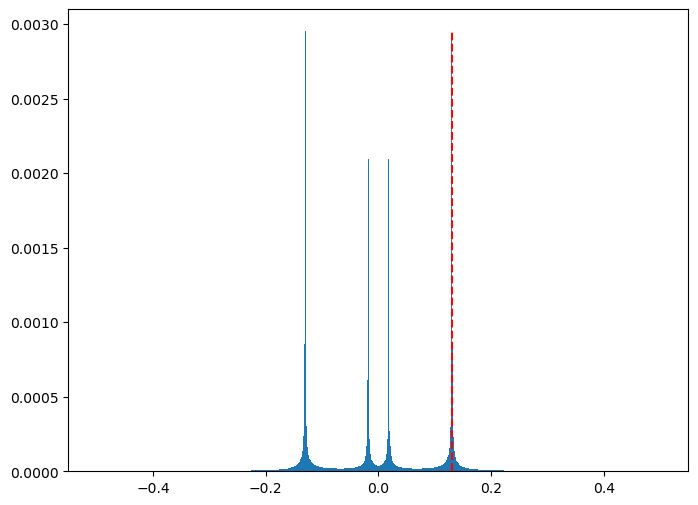

In [32]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
idx= 10
freq_cont = np.fft.fft(line.element_dict[f'{bpms_hor[0]}_monitor'].x[idx]+1j*line.element_dict[f'{bpms_hor[0]}_monitor'].px[idx])
freq = np.fft.fftfreq(len(freq_cont))
df = freq[1] - freq[0]  # frequency bin width

ax.bar(freq, np.abs(freq_cont),
       width=df, align='center')
ax.vlines(tw.qx%20, ymin=0, ymax=np.max(np.abs(freq_cont)), colors='r', linestyles='dashed', label='Expected tune')
# ax.plot(np.abs(freq_cont))

In [27]:
np.argmax(np.abs(freq_cont))

np.int64(871)

In [28]:
freq[871]

np.float64(-0.12987012987012986)

In [14]:
line.element_dict[f'{bpms_hor[0]}_monitor'].y[4]

array([0., 0., 0., ..., 0., 0., 0.], shape=(1001,))